In [1]:
import torch.nn as nn
import torch

In [2]:
import os
import shutil

import kagglehub

/home/jetal123/workdir/git_repo/breast_cancer_detection/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.create_annotation_file import CreateAnnotationFile
from src.create_dataset import BreastCancerDataset
from src.transforms import DataTransform
from src.dataloader import get_data_loader
from src.optimizer import create_optimizer
from src.simple_cnn_model import ImageClassifierCNN
from src.train_model import train_model
from src.save_model import save_data, save_model
from src.inference import infer
from src.threshold import get_best_thres
from src.evaluate import evaluate_model
from src.display_random_images import display_random_images


In [4]:
from torchvision.transforms import v2

In [5]:
# downloading dataset
local_path_dir = kagglehub.dataset_download("hayder17/breast-cancer-detection")

# create new folder to copy files from 'local_path_dir'
new_folder = "breast_cancer_data"

if not os.path.exists(f'{new_folder}'):
    os.makedirs(f'{new_folder}')

# copying all the files from 'local_path_dir'
shutil.copytree(local_path_dir, new_folder, dirs_exist_ok=True)

'breast_cancer_data'

In [6]:
# creating annotation files
dataset_dir_name = "breast_cancer_data"
subsets = ['train', 'test', 'valid'] 
destination_path = "annotation_files"

annotation_file_paths = []
annotation_file_name = []

for subset in subsets:
    annotation_creator = CreateAnnotationFile(dataset_dir_name, subset)
    annotation_df = annotation_creator.create_annotation_df()
    
    file_name, file_path = annotation_creator.save_annotation_file(annotation_df, destination_path)
    annotation_file_name.append(file_name)
    annotation_file_paths.append(file_path)


In [7]:
annotation_file_paths

['annotation_files/train_annotation.csv',
 'annotation_files/test_annotation.csv',
 'annotation_files/valid_annotation.csv']

In [8]:
annotation_file_name

['train_annotation.csv', 'test_annotation.csv', 'valid_annotation.csv']

In [9]:
# # defining transform config
train_transform_config = {
    "resize": {"size": (128, 128)},                 
    "random_horizontal_flip": {"p": 0.5},           
    "random_vertical_flip": {"p": 0.3},             
    "random_rotation": {"degrees": 15},             
    "brightness_contrast": {
        "brightness": 0.1, 
        "contrast": 0.1
        },
    "normalize": {
        "mean": [0.485, 0.456, 0.406],
        "std": [0.229, 0.224, 0.225],
    },
}
train_transform = DataTransform(user_config=train_transform_config)


In [10]:
train_transform = train_transform.get_transform()
train_transform

Compose(
      Resize(size=[128, 128], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.3)
      RandomRotation(degrees=[-15.0, 15.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
      ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1))
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [11]:
val_transform_config = {
    "resize": {'size': (128, 128)},
    "normalize": {
        "mean": [0.485, 0.456, 0.406],
        "std": [0.229, 0.224, 0.225],
    }
}

val_transform = DataTransform(val_transform_config)

In [12]:
val_transform = val_transform.get_transform()
val_transform

Compose(
      Resize(size=[128, 128], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [13]:
train_dataset = BreastCancerDataset(csv_file= annotation_file_paths[0],
                                    image_transform= train_transform)

test_dataset = BreastCancerDataset(csv_file= annotation_file_paths[1],
                                  image_transform= val_transform)

val_dataset = BreastCancerDataset(csv_file= annotation_file_paths[2],
                                  image_transform= val_transform)


In [14]:
train_df = train_dataset.data_frame

In [15]:
train_dataset.data_frame.dtypes

image_path    object
label          int64
dtype: object

In [16]:
train_df.head()

,image_path,label
0,breast_cancer_data/train/1/53946_1239100800_pn...,1
1,breast_cancer_data/train/1/23693_1555452504_pn...,1
2,breast_cancer_data/train/1/2346_129609192_png....,1
3,breast_cancer_data/train/1/26871_2012134319_pn...,1
4,breast_cancer_data/train/1/10226_530620473_png...,1


In [17]:
val_df = val_dataset.data_frame

In [18]:
val_df.head()

,image_path,label
0,breast_cancer_data/valid/1/63056_1783998558_pn...,1
1,breast_cancer_data/valid/1/47055_102668587_png...,1
2,breast_cancer_data/valid/1/21067_1511749844_pn...,1
3,breast_cancer_data/valid/1/13845_1772525431_pn...,1
4,breast_cancer_data/valid/1/10130_613462606_png...,1


In [19]:
test_df = test_dataset.data_frame

In [20]:
test_df.head()

,image_path,label
0,breast_cancer_data/test/1/65198_712545807_png....,1
1,breast_cancer_data/test/1/17562_104106029_png....,1
2,breast_cancer_data/test/1/64018_259642159_png....,1
3,breast_cancer_data/test/1/6303_1731900075_png....,1
4,breast_cancer_data/test/1/6303_1106334075_png....,1


In [21]:
print(f"Train: {len(train_dataset)}")
print(f"Val: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

print(f"Train dtype: {train_df.dtypes}")
print(f"Val dtype: {val_df.dtypes}")
print(f"Test dtype: {test_df.dtypes}")

Train: 2372
Val: 675
Test: 336
Train dtype: image_path    object
label          int64
dtype: object
Val dtype: image_path    object
label          int64
dtype: object
Test dtype: image_path    object
label          int64
dtype: object


In [22]:
print(f'train_df null values: \n{train_df.isnull().sum()}\n')
print(f'val_df null values: \n{val_df.isnull().sum()}\n')
print(f'test_df null values: \n{test_df.isnull().sum()}\n')

train_df null values: 
image_path    0
label         0
dtype: int64

val_df null values: 
image_path    0
label         0
dtype: int64

test_df null values: 
image_path    0
label         0
dtype: int64



In [23]:
# Recreate dataloaders with smaller number of workers for debugging
train_dataloader = get_data_loader(dataset= train_dataset,
                                  batch_size= 16,
                                  shuffle= True,
                                  num_workers= 2)  

val_dataloader = get_data_loader(dataset= val_dataset,
                                batch_size= 16,
                                shuffle= False,
                                num_workers= 2)  

test_dataloader = get_data_loader(dataset= test_dataset,
                                   batch_size= 16,
                                   shuffle= False,
                                   num_workers= 2)  

In [24]:
model_config= {
    "input_channel": 3,
    "num_classes": 1,
    "conv_config": [
        {"out_channels": 16, "kernel_size": 3, "padding": 1},
        {"out_channels": 32, "kernel_size": 3, "padding": 1, "dropout": 0.1, "pool": True},
        {"out_channels": 64, "kernel_size": 3, "padding": 1, "dropout": 0.1},
        {"out_channels": 128, "kernel_size": 3, "padding": 1, "pool": True},
        {"out_channels": 128, "kernel_size": 3, "padding": 1, "dropout": 0.1},
        {"out_channels": 256, "kernel_size": 3, "padding": 1, "dropout": 0.1},
    ],
    "fc_config": [
        {"out_features": 256, "dropout": 0.2},
        {"out_features": 128, "dropout": 0.2},
        {"out_features": 128, "dropout": 0.1},
        {"out_features": 64},
    ]
}

In [25]:
cnn_model = ImageClassifierCNN(**model_config)

In [26]:
for layer, params in cnn_model.named_parameters():
    print(f"Layer: {layer} | Size: {params.size()}")

Layer: conv.0.weight | Size: torch.Size([16, 3, 3, 3])
Layer: conv.0.bias | Size: torch.Size([16])
Layer: conv.1.weight | Size: torch.Size([16])
Layer: conv.1.bias | Size: torch.Size([16])
Layer: conv.4.weight | Size: torch.Size([32, 16, 3, 3])
Layer: conv.4.bias | Size: torch.Size([32])
Layer: conv.5.weight | Size: torch.Size([32])
Layer: conv.5.bias | Size: torch.Size([32])
Layer: conv.9.weight | Size: torch.Size([64, 32, 3, 3])
Layer: conv.9.bias | Size: torch.Size([64])
Layer: conv.10.weight | Size: torch.Size([64])
Layer: conv.10.bias | Size: torch.Size([64])
Layer: conv.14.weight | Size: torch.Size([128, 64, 3, 3])
Layer: conv.14.bias | Size: torch.Size([128])
Layer: conv.15.weight | Size: torch.Size([128])
Layer: conv.15.bias | Size: torch.Size([128])
Layer: conv.18.weight | Size: torch.Size([128, 128, 3, 3])
Layer: conv.18.bias | Size: torch.Size([128])
Layer: conv.19.weight | Size: torch.Size([128])
Layer: conv.19.bias | Size: torch.Size([128])
Layer: conv.23.weight | Size: to

In [27]:
# define loss function
criterion = nn.BCEWithLogitsLoss()

In [28]:
# define optimizer
optimizer_config= {
    "optimizer_name": "adam",
    "optimizer_params": {"lr": 0.001},
}

In [29]:
# # set optimizer
optimizer = create_optimizer(model = cnn_model,
                             optimizer_name = optimizer_config.get('optimizer_name'),
                             optimizer_params= optimizer_config.get('optimizer_params'))

In [30]:
# training model
train_model(model = cnn_model,
            num_epochs=10,
            train_loader= train_dataloader,
            val_loader= val_dataloader,
            loss_criterion= criterion,
            optimizer= optimizer)

Epoch: 1 | train_loss_avg: 0.6662 | val_loss_avg: 0.6537
Epoch: 2 | train_loss_avg: 0.6527 | val_loss_avg: 0.6459
Epoch: 3 | train_loss_avg: 0.6482 | val_loss_avg: 0.6472
Epoch: 4 | train_loss_avg: 0.6462 | val_loss_avg: 0.6433
Epoch: 5 | train_loss_avg: 0.6450 | val_loss_avg: 0.6411
Epoch: 6 | train_loss_avg: 0.6409 | val_loss_avg: 0.6374
Epoch: 7 | train_loss_avg: 0.6416 | val_loss_avg: 0.6370
Epoch: 8 | train_loss_avg: 0.6402 | val_loss_avg: 0.6330
Epoch: 9 | train_loss_avg: 0.6368 | val_loss_avg: 0.6315
Epoch: 10 | train_loss_avg: 0.6351 | val_loss_avg: 0.6334
Finished Training


In [31]:
model_config_new = {
    "input_channel": 3,
    "num_classes": 1,  
    "conv_config": [
        {"out_channels": 8, "kernel_size": 3, "padding": 1},  
        {"out_channels": 16, "kernel_size": 3, "padding": 1, "pool": True},
        {"out_channels": 32, "kernel_size": 3, "padding": 1, "pool": True},
    ],
    "fc_config": [
        {"out_features": 64}, 
        {"out_features": 32},
    ]
}

In [32]:
# create a model
cnn_model_new = ImageClassifierCNN(**model_config_new)

In [33]:
train_model(model = cnn_model_new,
            num_epochs=10,
            train_loader= train_dataloader,
            val_loader= val_dataloader,
            loss_criterion= criterion,
            optimizer= optimizer)

Epoch: 1 | train_loss_avg: 0.6925 | val_loss_avg: 0.6891
Epoch: 2 | train_loss_avg: 0.6925 | val_loss_avg: 0.6892
Epoch: 3 | train_loss_avg: 0.6918 | val_loss_avg: 0.6891
Epoch: 4 | train_loss_avg: 0.6921 | val_loss_avg: 0.6891
Epoch: 5 | train_loss_avg: 0.6914 | val_loss_avg: 0.6889
Epoch: 6 | train_loss_avg: 0.6925 | val_loss_avg: 0.6895
Epoch: 7 | train_loss_avg: 0.6915 | val_loss_avg: 0.6890
Epoch: 8 | train_loss_avg: 0.6928 | val_loss_avg: 0.6889
Epoch: 9 | train_loss_avg: 0.6923 | val_loss_avg: 0.6886
Epoch: 10 | train_loss_avg: 0.6919 | val_loss_avg: 0.6893
Finished Training


In [34]:
print(cnn_model.state_dict())

OrderedDict([('conv.0.weight', tensor([[[[-1.6718e-01,  1.1315e-01, -6.2274e-02],
          [-1.5280e-02,  2.8661e-02,  1.7987e-01],
          [ 1.6704e-01, -8.0572e-02,  1.9226e-01]],

         [[-2.0566e-01, -1.8917e-01, -1.4164e-01],
          [-1.5008e-01,  4.6971e-03, -1.0271e-01],
          [-8.9190e-02, -1.5021e-02,  1.7545e-01]],

         [[ 1.3307e-01,  4.5848e-02, -1.8762e-01],
          [-4.4224e-02, -3.0380e-02,  1.6110e-01],
          [ 1.0905e-01,  2.3291e-02,  8.6639e-02]]],


        [[[-7.0800e-02, -1.5139e-01,  9.4883e-02],
          [ 5.2520e-02, -1.6473e-01,  1.1134e-01],
          [ 5.6914e-02, -1.0214e-01, -2.7581e-02]],

         [[ 1.4940e-01,  1.1242e-01, -1.1708e-01],
          [-1.1225e-01,  1.0866e-01, -1.3887e-01],
          [-1.1595e-01,  1.2837e-01, -1.6661e-01]],

         [[ 1.8217e-01,  1.3227e-01,  7.8420e-02],
          [-5.3435e-02,  4.4016e-02, -6.0479e-02],
          [-7.3537e-02,  1.4308e-02, -1.8381e-01]]],


        [[[ 1.2371e-01, -7.2839e-02

In [35]:
print(optimizer.state_dict())

{'state': {0: {'step': tensor(1490.), 'exp_avg': tensor([[[[ 3.8066e-04,  3.9255e-04,  3.7691e-04],
          [ 7.2337e-04,  5.9659e-04,  5.0448e-04],
          [ 3.7970e-04,  4.0520e-04,  3.4913e-04]],

         [[ 3.8811e-04,  3.9769e-04,  3.8799e-04],
          [ 7.3939e-04,  6.0813e-04,  5.2172e-04],
          [ 3.9523e-04,  4.1848e-04,  3.6965e-04]],

         [[ 3.9068e-04,  3.9652e-04,  3.9918e-04],
          [ 7.4133e-04,  6.0691e-04,  5.3205e-04],
          [ 4.1043e-04,  4.3023e-04,  3.9270e-04]]],


        [[[ 3.7139e-04,  3.7508e-04,  3.7588e-04],
          [ 2.5292e-04,  2.4172e-04,  2.5850e-04],
          [ 2.0542e-04,  2.0161e-04,  2.3344e-04]],

         [[ 3.7999e-04,  3.8405e-04,  3.8482e-04],
          [ 2.5840e-04,  2.4732e-04,  2.6448e-04],
          [ 2.0921e-04,  2.0570e-04,  2.3826e-04]],

         [[ 3.7794e-04,  3.8255e-04,  3.8322e-04],
          [ 2.5610e-04,  2.4566e-04,  2.6263e-04],
          [ 2.0622e-04,  2.0333e-04,  2.3567e-04]]],


        [[[ 1.438

In [36]:
# save the model
save_data(
    cnn_model,
    optimizer,
    './model/model_state_dict.pth',
    './model/optimizer_state_dict.pth')

In [37]:
save_data(
    cnn_model_new,
    optimizer,
    './model/model_state_dict_new.pth',
    './model/optimizer_state_dict_new.pth')

In [38]:
save_model(cnn_model_new, './model/cnn_model_new.pth')
save_model(cnn_model, './model/cnn_model.pth')

In [39]:
# getting predictions on test data
cnn_model.eval()
with torch.no_grad():
    all_outputs = []
    all_labels = []
    for images, labels in test_dataloader:
        outputs = cnn_model(images)
        all_outputs.append(outputs)
        all_labels.append(labels)
        
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)


In [40]:
all_outputs[:10]

tensor([[-0.6281],
        [-0.4830],
        [-0.4884],
        [-0.6758],
        [-0.6836],
        [-0.4827],
        [-0.5326],
        [-0.4891],
        [-0.5501],
        [-0.7010]])

In [41]:
all_labels[:10]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [42]:
all_outputs = torch.sigmoid(all_outputs)
all_outputs = (all_outputs >= 0.5).float()
all_outputs[:10]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [43]:
all_pred, all_prob, all_labels = infer(cnn_model, test_dataloader, thres=0.5)

In [44]:
all_pred[:10]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.int32)

In [45]:
all_prob[:10]

tensor([[0.3479],
        [0.3815],
        [0.3803],
        [0.3372],
        [0.3354],
        [0.3816],
        [0.3699],
        [0.3801],
        [0.3659],
        [0.3316]])

In [46]:
all_labels = all_labels.unsqueeze(1)
all_labels.ndim

2

In [47]:
all_labels[:10]

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

In [48]:
best_thres = get_best_thres(all_prob, all_labels)

In [49]:
best_thres

tensor(0.3200)

In [53]:
all_pred, all_prob, all_labels = infer(cnn_model, test_dataloader, best_thres)

In [54]:
all_pred[:10]

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.int32)

In [55]:
evaluate_model(all_pred, all_labels.unsqueeze(1))

{'accuracy': 0.3898809552192688,
 'precision': 0.3843843936920166,
 'recall': 1.0,
 'f1_score': 0.5553145408630371}

In this example we see that the model is not learning very well which is evident from train_loss and val_loss. There can be many reasons behind this like:
1. Improper dataset
2. Imbalanced dataset
3. Simple model config
4. Inaccurate hyperparameters

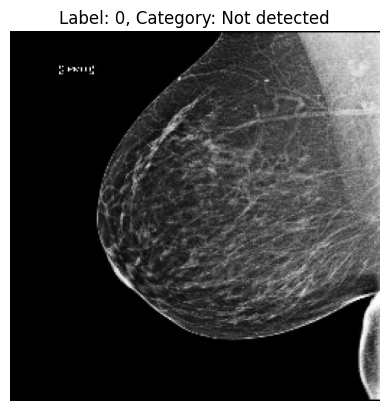

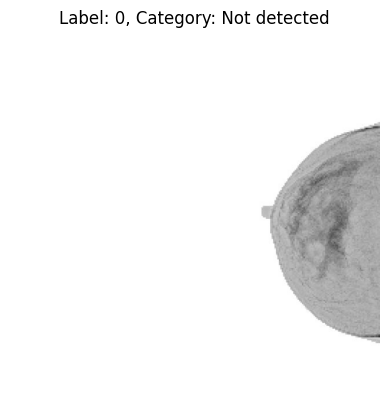

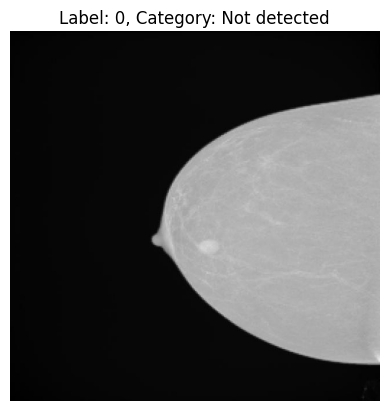

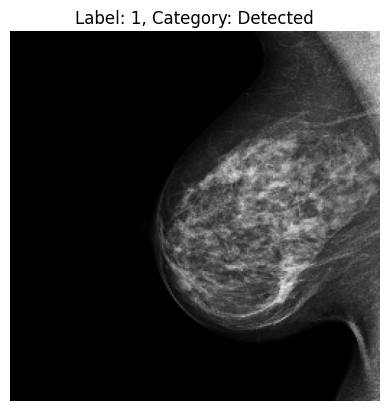

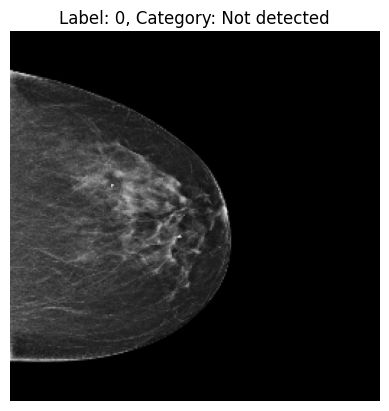

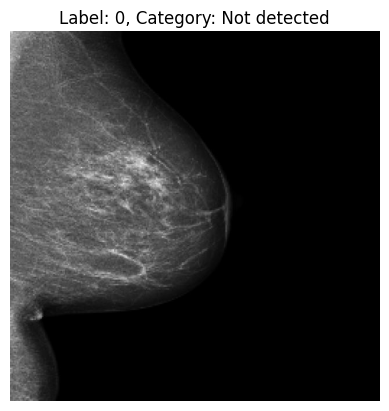

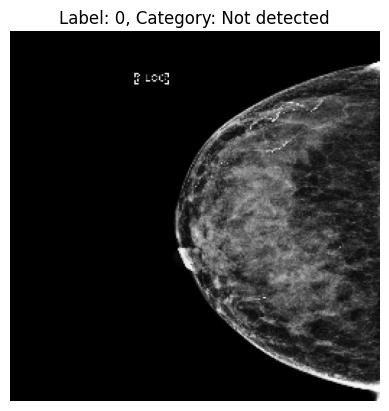

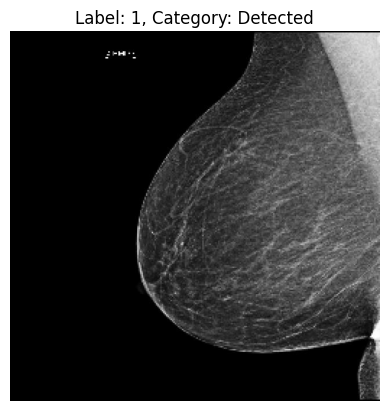

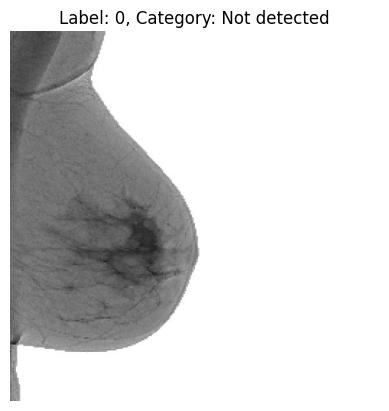

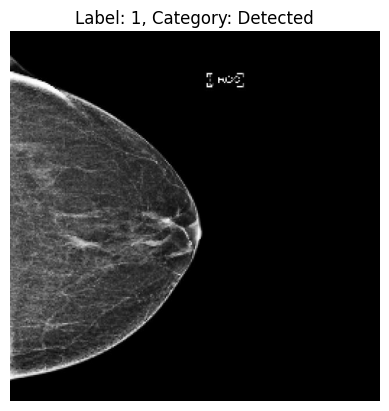

In [57]:
display_random_images(train_df, 10)

From the above sample images, we can see that our dataset is not accurate and has many wrong labels for the images.

In [58]:
# number of samples for each class in train, val and test datasets
print(f"Train dataset:\n{train_df['label'].value_counts()}\n")
print(f"Val dataset:\n{val_df['label'].value_counts()}\n")
print(f"Test dataset:\n{test_df['label'].value_counts()}\n")

Train dataset:
label
0    1569
1     803
Name: count, dtype: int64

Val dataset:
label
0    448
1    227
Name: count, dtype: int64

Test dataset:
label
0    208
1    128
Name: count, dtype: int64



From the above instance, we can see that our dataset is highly imbalanced, which means that the training of a model is not very accurate. the model predicts more of a 'Not Detected' (0) label, which can also be observed from the predicted labels.

The better way to handle imbalanced dataset can be: 
1. Using `pos_weight` in BCEWithLogitsLoss which makes the loss penalize misclassified postives more heavily.
2. Using `WeightedRandomSampler` for the DataLoader which oversamples the minority class without physically duplicating data

Combining these two method can ensure balanced batches in the DataLoader.

Another method to make the model better is to tune the hyperparameters which can help to optimize the performance. Some of the ways of tuning hyperparameters can be:
1. Using `GridSearchCV` which searches over a predefined set of hyperparameter values.
2. Using `RandomizedSearchCV` which samples hyperparameters randomly from a distribution